In [96]:
import matplotlib.pyplot as plt
#%matplotlib inline

import pandas as pd
import numpy as np
from math import ceil

In [97]:
import io
import requests
Content = requests.get("https://raw.githubusercontent.com/flmath-dirty/matrixes_in_erlang/master/results.cvs").content
LoadedTable= pd.read_csv(io.StringIO(Content.decode('utf-8')),skipinitialspace=True,
                  names=['Test type', 'Width', 'Height','Matrix representation','No. of calls', 'Execution time'])

The LoadedTable contains statistics gathered from running the script that generates a matrix (Width x Height) and then 
runs with the [fprof](http://erlang.org/doc/man/fprof.html) following tests for each representation of matrix and sizes:

The tests categories:

 - one_rows_sums - sum of values from each row in the matrix
 
 - one_cols_sums - sum of values from each row in the matrix
 
 - get_value - gets each value from the matrix once separetly
 
 - set_value - sets each value from the matrix once separetly 



Matrixes are represented as follow:
 - [sofs](http://erlang.org/doc/man/sofs.html): Set of the sets module is a way of representing relations (in strictly mathematical sense). In this case the matrix is represented as a relation (a function) F where domain is constructed from coordinates which is related to the matrix entry value ({x,y} F Value).
 
 To get values in specific row we define equivalence relation aRb iff thera are {x,y1} F a {x,y2} F b.
 This relation divides antidomain in abbstract classes. If we sum elements belonging to the abstract class with element {x,_} we will get sum of the elements from this specific row. We use the same logic to receive abstrac classes for columns.
 
 
 - [digraph](http://erlang.org/doc/man/digraph.html): We have a directed graph where each value is stored in vertex with the coordinate {x,y}. Aside of that each column and row has dedicated vertex with edges from corresponding coordinate vertexes directed at it to speed up rows and columns sums calculations.
 
 
 - [array](http://erlang.org/doc/man/array.html): The matrix is represented as a tuple {Width, Height, Array}, where the array has size Width * Height, all operations are done with simply calculating positions of the values in the array.
 
 
 - big tuple: The matrix is represented as a tuple {Width, Height, BigTuple} where the BigTuple is tuple used in the same way as the Array from previous point (note: arrays indexing starts from 0).
 
 
 - [map]{http://erlang.org/doc/man/maps.html): A quite fresh data structure in Erlang, we map coordinates {x,y} to values.
 
 
 - List of the lists: Each of sublists of the list contains elements representing  values in the row. Since it visually resembles a matrix, it is quite often abused by coders. Heavy usage of [lists]{http://erlang.org/doc/man/lists.html) module.

 I have run tests on the square matrixes of sizes 50x50, 100x100, 1000x1000. For some of the 1000x1000 tests fprof logs exceeded the dedicated 2TB disk size. For those the values are missing.

In [98]:
LoadedTable.head()

,Test type,Width,Height,Matrix representation,No. of calls,Execution time
0,one_rows_sums,50,50,matrix_as_sofs,20452,48.280
1,one_rows_sums,50,50,matrix_as_digraph,20531,59.981
2,one_rows_sums,50,50,matrix_as_array,18483,36.792
3,one_rows_sums,50,50,matrix_as_map,13684,42.790
4,one_rows_sums,50,50,matrix_as_big_tuple,5962,12.147


In [99]:
from scipy import stats
from functools import reduce
AggregatedTable = (LoadedTable.groupby(['Test type','Matrix representation'])['Execution time']
                   .apply(list).reset_index(name='Execution Times List'))

Create aggregate table with execution time values for different size of matrixes stored in one list.

In [100]:
AggregatedTable.head()

,Test type,Matrix representation,Execution Times List
0,get_value,matrix_as_array,"[59.462, 232.601, 28018.33]"
1,get_value,matrix_as_big_tuple,"[25.176, 121.824, 12527.693]"
2,get_value,matrix_as_digraph,"[42.854, 211.419, 19704.339]"
3,get_value,matrix_as_list_of_lists,"[280.91, 2073.251]"
4,get_value,matrix_as_map,"[36.883, 159.307, 15976.373]"


Each list should have 3 values, if one is missing it means it exceeded testing capability of my equipment, and can be considered infinite. Also add columns with minimum values, maximum values and harmonic averages (since standard average would be too susceptible to outliers here).

In [101]:
AggregatedTable['Harmonic Average'] = AggregatedTable['Execution Times List'].apply(
    lambda x: stats.hmean(x) if (len(x) == 3) else np.inf)

In [102]:
AggregatedTable['Max'] = AggregatedTable['Execution Times List'].apply(
    lambda x: max(x) if (len(x) == 3) else np.inf)

In [103]:
AggregatedTable['Min'] = AggregatedTable['Execution Times List'].apply(min)

In [104]:
AggregatedTable.head()

,Test type,Matrix representation,Execution Times List,Harmonic Average,Max,Min
0,get_value,matrix_as_array,"[59.462, 232.601, 28018.33]",141.828134,2.801833e+04,59.462
1,get_value,matrix_as_big_tuple,"[25.176, 121.824, 12527.693]",62.488602,1.252769e+04,25.176
2,get_value,matrix_as_digraph,"[42.854, 211.419, 19704.339]",106.701803,1.970434e+04,42.854
3,get_value,matrix_as_list_of_lists,"[280.91, 2073.251]",inf,inf,280.910
4,get_value,matrix_as_map,"[36.883, 159.307, 15976.373]",89.679282,1.597637e+04,36.883


In [105]:
GetValue = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='get_value']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )
#GetValue.columns = GetValue.iloc[0]
GetValue = GetValue.set_index('Matrix representation')

In [106]:
from jupyter_extensions.matplotlib.sawed_bar_plot import sawed_bar_plot

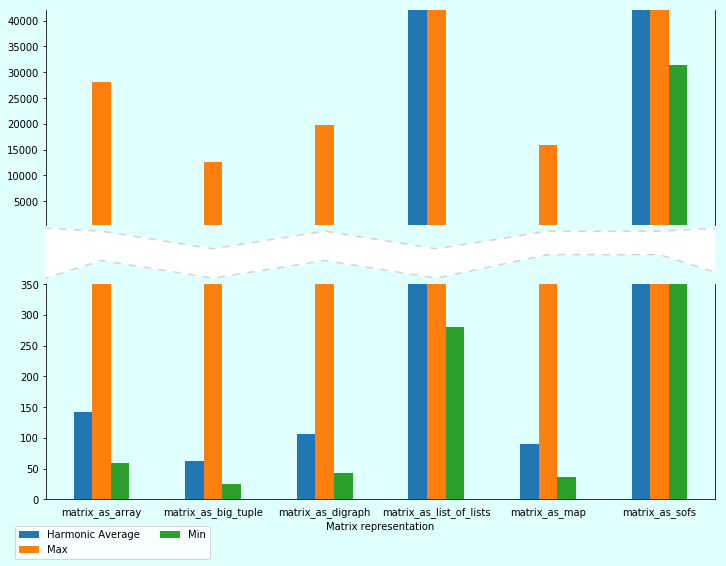

In [107]:
sawed_bar_plot(GetValue)

In [108]:
SetValue = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='set_value']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )

SetValue = SetValue.set_index('Matrix representation')

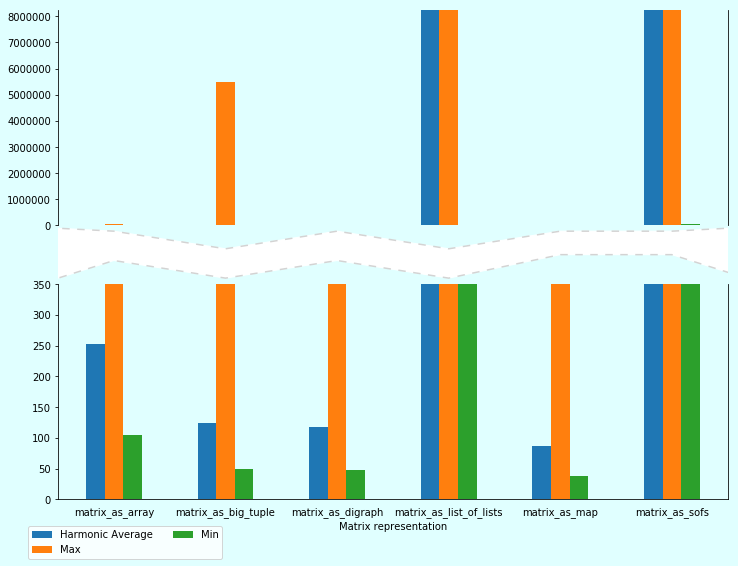

In [109]:
sawed_bar_plot(SetValue)

In [110]:
OneColsSums = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='one_cols_sums']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )

OneColsSums = OneColsSums.set_index('Matrix representation')

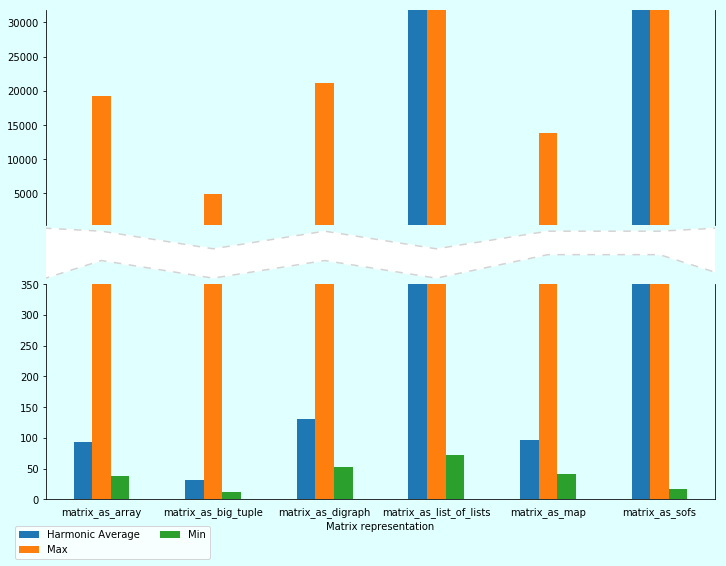

In [111]:
sawed_bar_plot(OneColsSums)

In [112]:
OneRowsSums = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='one_rows_sums']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )

OneRowsSums = OneRowsSums.set_index('Matrix representation')

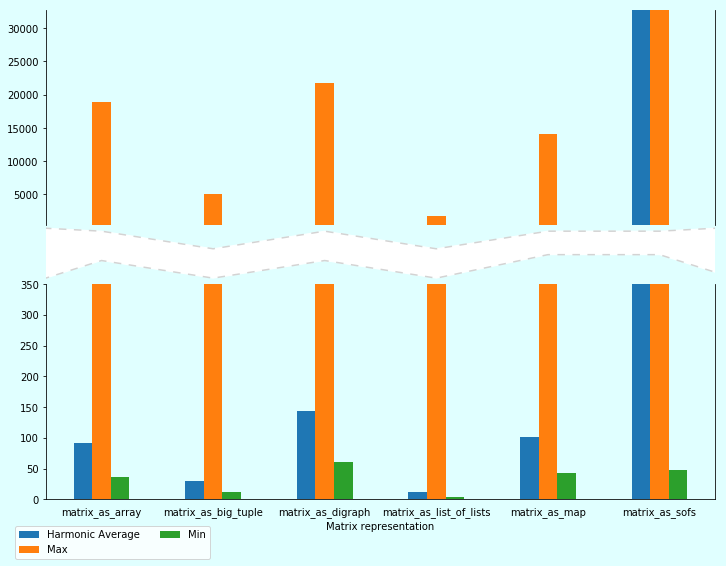

In [113]:
sawed_bar_plot(OneRowsSums)